In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats as stat
import scipy.optimize
import math
import pickle

In [2]:
def dual_model_sudden(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    rotation = 90/90.0
    fast_est = np.zeros((num_trials))
    slow_est = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    #rotation_est[0] = est
    for trial in range(num_trials - 1):
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        fast_est[trial+1] = Af*fast_est[trial] + Bf*errors[trial]
        slow_est[trial+1] = As*slow_est[trial] + Bs*errors[trial]
        rotation_est[trial+1] = fast_est[trial+1] + slow_est[trial+1]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est, fast_est, slow_est

def dual_model_gradual(num_trials, Af, Bf, As, Bs):
    errors = np.zeros((num_trials))
    fast_est = np.zeros((num_trials))
    slow_est = np.zeros((num_trials))
    rotation_est = np.zeros((num_trials))
    rotation = 0
    for trial in range(num_trials - 1):
        if trial%64 == 0:
            rotation = rotation + 10/90.0
        if rotation > 90/90:
            rotation = 90/90
        errors[trial] = rotation - rotation_est[trial]
        #print(errors[trial])
        fast_est[trial+1] = Af*fast_est[trial] + Bf*errors[trial]
        slow_est[trial+1] = As*slow_est[trial] + Bs*errors[trial]
        rotation_est[trial+1] = fast_est[trial+1] + slow_est[trial+1]
        #print (rotation_est)
    errors[num_trials-1] = rotation - rotation_est[num_trials-1]
    return errors, rotation_est, fast_est, slow_est

In [3]:
def residuals_sudden(params, num_trials, data_errors):
    model_errors = dual_model_sudden(num_trials, params[0], params[1], params[2], params[3])[0]
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

def residuals_gradual(params, num_trials, data_errors):
    model_errors = dual_model_gradual(num_trials, params[0], params[1], params[2], params[3])[0]
    residual_error = np.sum(np.square(model_errors - data_errors))
    if params[0] > params[2]:
        residual_error = residual_error + 10000000
    if params[1] < params[3]:
        residual_error = residual_error + 10000000
    if params[0] < 0 or params[1] < 0 or params[2] < 0 or params[3] < 0:
        residual_error = residual_error + 10000000
    return residual_error

In [4]:
def fit_participant(participant, curvatures, num_fits):

    for fit_parts in range(num_fits):

        starting_points = np.array([[0.6, 0.5, 0.7, 0.1]])
        for initial_point in starting_points:
            if participant%4 == 0 or participant%4 == 1:      
                #fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                #fits = scipy.optimize.basinhopping(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})

                #if fits.fun < fit_V[participant][fit_parts]:
                Af = fits.x[0]#fit_Af[participant][fit_parts] = fits.x[0]
                Bf = fits.x[1]#fit_Bf[participant][fit_parts] = fits.x[1]
                As = fits.x[2]#fit_As[participant][fit_parts] = fits.x[2]
                Bs = fits.x[2]#fit_Bs[participant][fit_parts] = fits.x[3]
                V = fits.fun#fit_V[participant][fit_parts] = fits.fun
                #fit_success[participant][fit_parts] = fits.success                
            else:
                #fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                fits = scipy.optimize.basinhopping(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})
                #if fits.fun < fit_V[participant][fit_parts]:
                Af = fits.x[0]#fit_Af[participant][fit_parts] = fits.x[0]
                Bf = fits.x[1]#fit_Bf[participant][fit_parts] = fits.x[1]
                As = fits.x[2]#fit_As[participant][fit_parts] = fits.x[2]
                Bs = fits.x[2]#fit_Bs[participant][fit_parts] = fits.x[3]
                V = fits.fun#fit_V[participant][fit_parts] = fits.fun
                #fit_success[participant][fit_parts] = fits.success
    return Af, Bf, As, Bs, V


In [16]:
#Divide the whole thing into 16 trial blocks and fit them
from functools import partial
def run_fits_dual(curvatures, num_trials, part_size):
    num_fits = int(num_trials/part_size)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        fit_Af[participant], fit_Bf[participant], fit_As[participant], fit_Bs[participant], fit_V[participant] = fit_participant(participant, curvatures, num_fits) 
        print (participant, fit_V[participant])
    #unc = partial(workers.fit_participant, curvatures = curvatures, num_fits = 1)
    #if __name__ == '__main__':
    #    pool = Pool()
    #res = np.reshape(np.array(pool.map(func, range(60))), (60, 5))
    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_V
    #return res   

In [5]:
def fit_participant_singlestart(participant, curvatures, num_fits, A, B):

    for fit_parts in range(num_fits):

        starting_points = np.array([[0.6, 0.5, A, B]])
        for initial_point in starting_points:
            if participant%4 == 0 or participant%4 == 1:      
                fits = scipy.optimize.minimize(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')            
                #fits = scipy.optimize.basinhopping(residuals_sudden, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})

                #if fits.fun < fit_V[participant][fit_parts]:
                Af = fits.x[0]#fit_Af[participant][fit_parts] = fits.x[0]
                Bf = fits.x[1]#fit_Bf[participant][fit_parts] = fits.x[1]
                As = fits.x[2]#fit_As[participant][fit_parts] = fits.x[2]
                Bs = fits.x[3]#fit_Bs[participant][fit_parts] = fits.x[3]
                V = fits.fun#fit_V[participant][fit_parts] = fits.fun
                #fit_success[participant][fit_parts] = fits.success                
            else:
                fits = scipy.optimize.minimize(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], args = (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), method = 'Nelder-Mead')         
                #fits = scipy.optimize.basinhopping(residuals_gradual, x0 = [initial_point[0], initial_point[1], initial_point[2], initial_point[3]], minimizer_kwargs={'args': (640, np.nan_to_num(np.ravel(curvatures[participant][1:-1]), nan = np.nanmedian(curvatures[participant][1:-1]))), 'method': 'Nelder-Mead'})
                #if fits.fun < fit_V[participant][fit_parts]:
                Af = fits.x[0]#fit_Af[participant][fit_parts] = fits.x[0]
                Bf = fits.x[1]#fit_Bf[participant][fit_parts] = fits.x[1]
                As = fits.x[2]#fit_As[participant][fit_parts] = fits.x[2]
                Bs = fits.x[3]#fit_Bs[participant][fit_parts] = fits.x[3]
                V = fits.fun#fit_V[participant][fit_parts] = fits.fun
                #fit_success[participant][fit_parts] = fits.success
    return Af, Bf, As, Bs, V


In [ ]:
#Divide the whole thing into 16 trial blocks and fit them
from functools import partial
def run_fits_dual_singlestart(curvatures, num_trials, single_params):
    num_fits = int(num_trials)
    fit_As = np.zeros((60, num_fits))
    fit_Bs = np.zeros((60, num_fits))
    fit_Af = np.zeros((60, num_fits))
    fit_Bf = np.zeros((60, num_fits))
    fit_V = np.full((60, num_fits), np.inf)
    fit_success = np.zeros((60, num_fits))

    for participant in range(60):
        fit_Af[participant], fit_Bf[participant], fit_As[participant], fit_Bs[participant], fit_V[participant] = fit_participant(participant, curvatures, num_fits, single_params[participant]) 
        print (participant, fit_V[participant])
    #unc = partial(workers.fit_participant, curvatures = curvatures, num_fits = 1)
    #if __name__ == '__main__':
    #    pool = Pool()
    #res = np.reshape(np.array(pool.map(func, range(60))), (60, 5))
    return fit_Af, fit_Bf, fit_As, fit_Bs, fit_V
    #return res   

In [19]:
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90
Af, Bf, As, Bs, fit_V_dual = run_fits_dual(curvatures_smooth, 640, 640)
#fits = run_fits_dual(curvatures_smooth, 640, 640)

0 [9.87815647]


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Tejas\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


1 [8.81488848]


C:\Users\Tejas\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  


2 [10.23524566]
3 [4.46128064]
4 [4.77646038]
5 [8.65257811]
6 [1.25599045]


KeyboardInterrupt: 

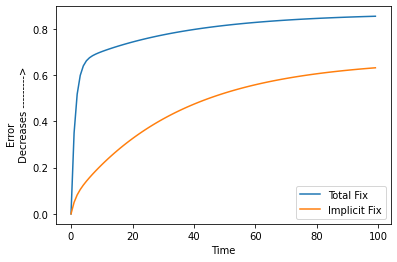

In [45]:
e, r, f, s = dual_model_sudden(100, 0.8, 0.3, 0.99, 0.05)
plot0, = plt.plot(r)
#plot1, = plt.plot(1 - e - s)
plot2, = plt.plot(1 - e - f)

plt.legend([plot0, plot2], ['Total Fix', 'Implicit Fix'])
plt.ylabel('Error            \n Decreases --------->')
plt.xlabel('Time')
plt.savefig('dual_theoretical_rot_imp_est.png', dpi = 600)

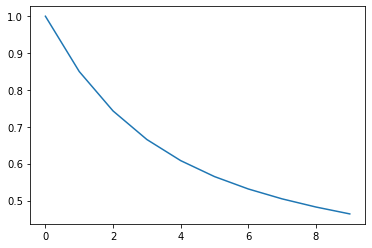